In [1]:
import os
os.environ['PATH'] += ':ffmpeg-3.4.2-64bit-static'

# Setup

In [2]:
exp_directory = 'results'
agent_name = 'DeepQAgent'
game_name = 'Seaquest'
render_mode='rgb_array'

### Global Modules

In [3]:
import os
import datetime
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
from gym.wrappers import Monitor

### Local Modules

In [4]:
import base
from src.agents import DeepQAgent, A3CAgent
from src.util import BaseCallback, JupyterCallback
from src.environment.atari import build_atari_environment

/usr/local/anaconda5/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/usr/local/anaconda5/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


## Constants

In [5]:
agents = {
    DeepQAgent.__name__: DeepQAgent,
    A3CAgent.__name__: A3CAgent,
}

#### Output Directory

In [6]:
# setup the experiment directory
now = datetime.datetime.today().strftime('%Y-%m-%d_%H-%M')
exp_directory = '{}/{}/{}/{}'.format(exp_directory, game_name, agent_name, now)
if not os.path.exists(exp_directory):
    os.makedirs(exp_directory)
exp_directory

'results/Seaquest/DeepQAgent/2018-04-16_01-56'

In [7]:
plot_dir = '{}/plots'.format(exp_directory)
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)
plot_dir

'results/Seaquest/DeepQAgent/2018-04-16_01-56/plots'

# Environment

In [8]:
env = build_atari_environment(game_name)
env = Monitor(env, '{}/monitor'.format(exp_directory), force=True)

In [9]:
env.observation_space

Box(84, 84, 4)

In [10]:
env.action_space

Discrete(18)

# Agent

In [11]:
agent = agents[agent_name](env, render_mode=render_mode)
agent

DeepQAgent(
    env=<Monitor<FrameStackEnv<ClipRewardEnv<PenalizeDeathEnv<DownsampleEnv<FireResetEnv<MaxFrameskipEnv<NoopResetEnv<TimeLimit<AtariEnv<SeaquestNoFrameskip-v4>>>>>>>>>>>,
    render_mode='rgb_array'
    replay_memory_size=1000000,
    discount_factor=0.99,
    update_frequency=4,
    optimizer=<keras.optimizers.Adam object at 0x2afb538c4240>,
    exploration_rate=AnnealingVariable(initial_value=1.0, final_value=0.1, steps=1000000),
    loss=huber_loss,
    target_update_freq=10000,
    dueling_network=True
)

In [12]:
# write some info about the agent to disk
with open('{}/agent.py'.format(exp_directory), 'w') as agent_file:
    agent_file.write(repr(agent))

## Initial

In [13]:
initial = agent.play()
initial = pd.Series(initial)
initial

100%|██████████| 100/100 [02:49<00:00,  1.70s/game]


0     3.0
1     0.0
2     1.0
3     0.0
4     0.0
5     2.0
6     0.0
7     1.0
8     0.0
9     0.0
10    1.0
11    1.0
12    0.0
13    0.0
14    0.0
15    1.0
16    0.0
17    0.0
18    0.0
19    1.0
20    1.0
21    2.0
22    0.0
23    0.0
24    0.0
25    0.0
26    3.0
27    1.0
28    1.0
29    0.0
     ... 
70    0.0
71    0.0
72    1.0
73    0.0
74    0.0
75    1.0
76    0.0
77    2.0
78    0.0
79    0.0
80    1.0
81    0.0
82    1.0
83    1.0
84    1.0
85    0.0
86    0.0
87    0.0
88    0.0
89    0.0
90    1.0
91    0.0
92    0.0
93    1.0
94    0.0
95    1.0
96    0.0
97    0.0
98    2.0
99    0.0
Length: 100, dtype: float64

In [14]:
initial.to_csv('{}/initial.csv'.format(exp_directory))

In [15]:
initial.describe()

count    100.00000
mean       0.61000
std        0.80271
min        0.00000
25%        0.00000
50%        0.00000
75%        1.00000
max        3.00000
dtype: float64

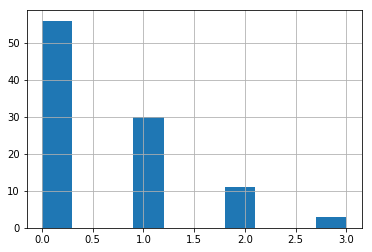

In [16]:
initial.hist()
plt.savefig('{}/initial.pdf'.format(plot_dir))

## Training

In [17]:
agent.observe()

50131frame [00:55, 899.75frame/s]                        


In [18]:
callback = BaseCallback()

In [19]:
agent.train(callback=callback)

 98%|█████████▊| 9753069/10000000 [17:14:05<25:48, 159.45frame/s, loss=0.791, score=112]  

KeyboardInterrupt: 

 98%|█████████▊| 9753069/10000000 [17:14:23<25:48, 159.45frame/s, loss=0.791, score=112]

In [20]:
# save the training results
scores = pd.Series(callback.scores)
scores.to_csv('{}/scores.csv'.format(exp_directory))
losses = pd.Series(callback.losses)
losses.to_csv('{}/losses.csv'.format(exp_directory))

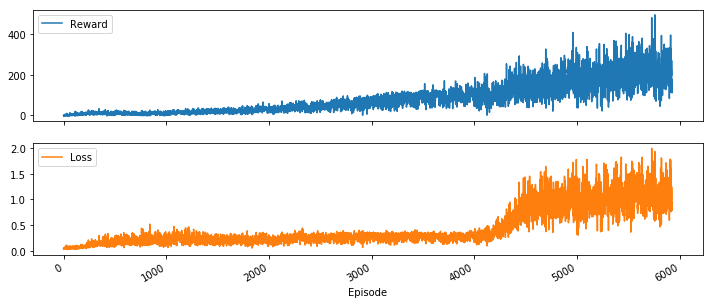

In [21]:
train = pd.concat([scores, losses], axis=1)
train.columns = ['Reward', 'Loss']
train.index.name = 'Episode'
_ = train.plot(figsize=(12, 5), subplots=True)
plt.savefig('{}/training.pdf'.format(plot_dir))

## Final

In [23]:
final = agent.play()
final = pd.Series(final)
final


100%|██████████| 100/100 [13:54<00:00,  8.34s/game]


0     226.0
1     288.0
2     262.0
3     122.0
4     211.0
5     112.0
6     362.0
7     143.0
8     346.0
9     385.0
10    192.0
11    153.0
12    404.0
13    323.0
14    152.0
15     89.0
16    330.0
17    185.0
18    417.0
19    281.0
20    127.0
21    160.0
22    400.0
23    193.0
24     73.0
25    135.0
26    350.0
27    256.0
28    317.0
29    280.0
      ...  
70    362.0
71    208.0
72    271.0
73    236.0
74    322.0
75    405.0
76    266.0
77    370.0
78    399.0
79    193.0
80    105.0
81    157.0
82    352.0
83    206.0
84    263.0
85    186.0
86    251.0
87    386.0
88    237.0
89    180.0
90    356.0
91    435.0
92    236.0
93    335.0
94    357.0
95    305.0
96    186.0
97    318.0
98    317.0
99    218.0
Length: 100, dtype: float64

In [24]:
final.to_csv('{}/final.csv'.format(exp_directory))

In [25]:
final.describe()

count    100.000000
mean     263.440000
std       91.853674
min       73.000000
25%      193.000000
50%      255.500000
75%      336.000000
max      447.000000
dtype: float64

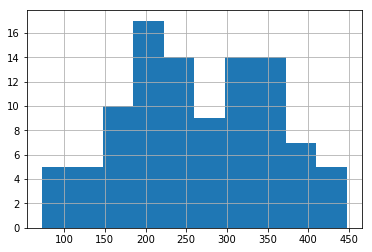

In [26]:
final.hist()
plt.savefig('{}/final.pdf'.format(plot_dir))

## Saving Weights

In [27]:
agent.model.save_weights('{}/weights.h5'.format(exp_directory), overwrite=True)